In [33]:
# This script installs the required Python packages listed in requirements.txt
#!pip install -r requirements.txt


In [34]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
df_raw = pd.read_csv('all_data_raw.csv', parse_dates=['date'])

In [57]:
df_raw.columns

Index(['date', 'close_crypto', 'volume_crypto', 'ticker_crypto',
       'ln_volume_crypto', 'daily_growth_crypto', 'weekly_growth_crypto',
       'monthly_growth_crypto', 'vol_weekly_crypto', 'momentum_weekly_crypto',
       'ma_20_crypto', 'ma_50_crypto', 'ma_100_crypto', 'year', 'quarter',
       'quarter_end', 'close_stock', 'volume_stock', 'ticker_stock',
       'ln_volume_stock', 'daily_growth_stock', 'weekly_growth_stock',
       'monthly_growth_stock', 'vol_weekly_stock', 'momentum_weekly_stock',
       'ma_20_stock', 'ma_50_stock', 'ma_100_stock', 'positive_weekly_growth',
       'gdp_us', 'gdp_us_yoy', 'gdp_us_qoq', 'cpi_us', 'cpi_us_yoy',
       'cpi_us_qoq', 'unemployment_us', 'unemployment_us_yoy',
       'unemployment_us_qoq', 'interest_us', 'interest_us_yoy',
       'interest_us_qoq', 'gdp_de', 'gdp_de_yoy', 'gdp_de_qoq', 'cpi_de',
       'cpi_de_yoy', 'cpi_de_qoq', 'interest_eu', 'interest_eu_yoy',
       'interest_eu_qoq'],
      dtype='object')

In [58]:
df = df_raw.ffill().bfill()

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22455 entries, 0 to 22454
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    22455 non-null  datetime64[ns]
 1   close_crypto            22455 non-null  float64       
 2   volume_crypto           22455 non-null  float64       
 3   ticker_crypto           22455 non-null  object        
 4   ln_volume_crypto        22455 non-null  float64       
 5   daily_growth_crypto     22455 non-null  float64       
 6   weekly_growth_crypto    22455 non-null  float64       
 7   monthly_growth_crypto   22455 non-null  float64       
 8   vol_weekly_crypto       22455 non-null  float64       
 9   momentum_weekly_crypto  22455 non-null  float64       
 10  ma_20_crypto            22455 non-null  float64       
 11  ma_50_crypto            22455 non-null  float64       
 12  ma_100_crypto           22455 non-null  float6

In [60]:
df['positive_weekly_growth'].value_counts()

positive_weekly_growth
0.0    11553
1.0    10902
Name: count, dtype: int64

In [66]:
TO_PREDICT = ['positive_weekly_growth']
CATEGORICAL = ['ticker_crypto', 'ticker_stock']
TO_DROP = ['date', 'close_crypto', 'volume_crypto', 'close_stock', 'volume_stock', 'year', 'quarter', 
           'quarter_end'] + CATEGORICAL

In [67]:
#df[df["ticker_stock"] == "MARA"].head(10).T

In [68]:
#get dummy variables
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [69]:
#correlation
df_with_dummies.drop(columns = TO_DROP).corr()[TO_PREDICT].sort_values(by=TO_PREDICT, ascending=False)

,positive_weekly_growth
positive_weekly_growth,1.000000
weekly_growth_stock,0.719667
monthly_growth_stock,0.320195
weekly_growth_crypto,0.318761
daily_growth_stock,0.279871
vol_weekly_stock,0.169336
daily_growth_crypto,0.149712
monthly_growth_crypto,0.142490
interest_us,0.068878
ln_volume_stock,0.061768


In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
df_model = df_with_dummies.copy()

In [72]:

# 1. Sort chronologically
df_model = df_model.sort_values(['date']).reset_index(drop=True)

# 2. Automatic 80/20 date cutoff

start_date = df_model['date'].min()
end_date = df_model['date'].max()
cutoff_date = start_date + (end_date - start_date) * 0.8

print(f"Train: {start_date.date()} → {cutoff_date.date()}")
print(f"Test:  {cutoff_date.date()} → {end_date.date()}")

train_df = df_model[df_model['date'] < cutoff_date]
test_df  = df_model[df_model['date'] >= cutoff_date]

# 3. Features and target
X_train = train_df.drop(CATEGORICAL+TO_PREDICT+TO_DROP, axis=1)
y_train = train_df['positive_weekly_growth']

X_test  = test_df.drop(CATEGORICAL+TO_PREDICT+TO_DROP, axis=1)
y_test  = test_df['positive_weekly_growth']

# 4. Define model and param grid
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
# 5. TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Train: 2021-01-01 → 2024-09-25
Test:  2024-09-25 → 2025-09-01
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 0.9997994652406417


In [73]:
# 6. Train best model and evaluate

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2157
         1.0       1.00      1.00      1.00      2343

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



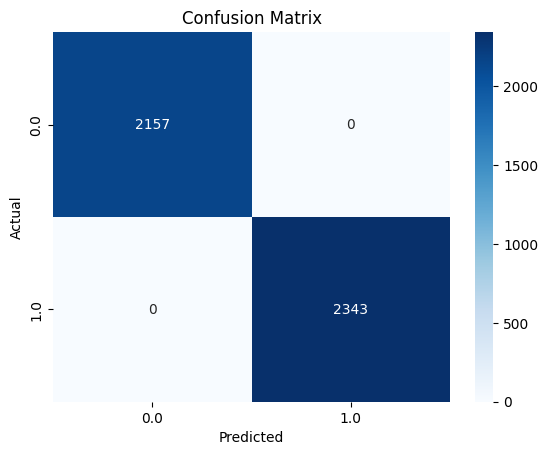

In [74]:
cm = confusion_matrix(y_test, y_pred)

labels = sorted(df['positive_weekly_growth'].unique())
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

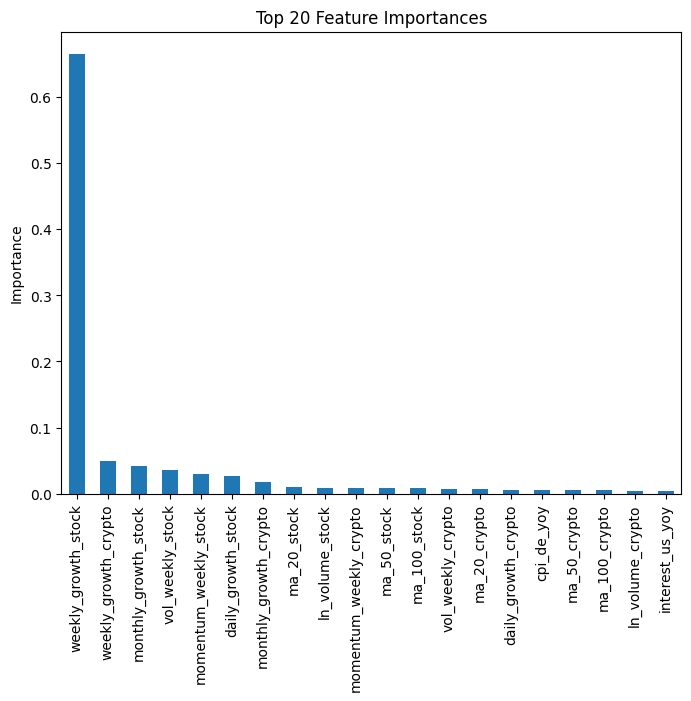

In [75]:
importances = grid_search.best_estimator_.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='bar')
plt.title('Top 20 Feature Importances')
plt.ylabel('Importance')
plt.show()

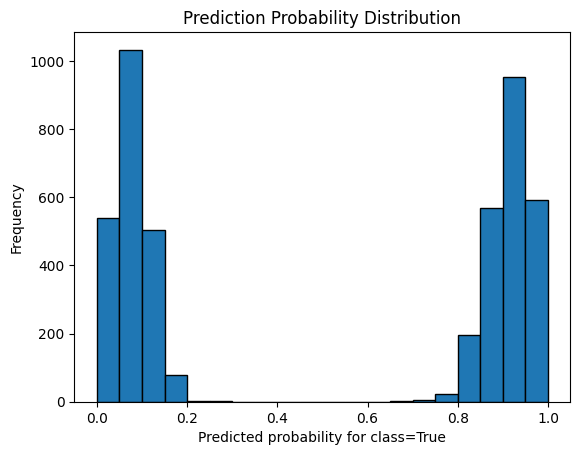

In [76]:
probs = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
plt.hist(probs, bins=20, edgecolor='k')
plt.xlabel('Predicted probability for class=True')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.show()

In [ ]:
# predict on a full dataset
y_pred_all = best_rf.predict(df_model.drop(CATEGORICAL+TO_PREDICT+TO_DROP, axis=1))
y_pred_all.shape